# Gaussian process introductory tutorial in Python

by: __Andreas Damianou__ - [andreasdamianou.com](http://www.andreasdamianou.com\)

_Latest update:_ October 2019

  
  
You can also see this notebook rendered in nbviewer [[LINK]](http://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Damianou_GP_tutorial.ipynb).


If you wish to cite this tutorial:

```
% Requires \usepackage{url} in preamble
@misc{DamianouGPtutorial,
 author = {Damianou, Andreas},
 title = {Gaussian process introductory tutorial in Python},
 url = {http://adamian.github.io/talks/Damianou_GP_tutorial.html}, 
 howpublished = {\url{http://adamian.github.io/talks/Damianou_GP_tutorial.html}},
 originalyear = {2019},
 lastchecked = {}
}
```

Import necessary libraries and modules

In [1]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


The following function will be handy for plotting the fit of a GP.

In [2]:
def plot_fit(x,y,mu,var, m_y='k-o', m_mu='b-<', l_y='true', l_mu='predicted', legend=True, title=''):
    """
    Plot the fit of a GP
    """
    if y is not None:
        plt.plot(x,y, m_y, label=l_y)
    plt.plot(x,mu, m_mu, label=l_mu)
    vv = 2*np.sqrt(var)
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
    if legend:
        plt.legend()
    if title != '':
        plt.title(title)

# Part 1: GP teaser    
Let's have a quick look at some of the things one can do with GPs. 

In [3]:
import GPy
import pods # For the datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model

#--- Data
y_train = pods.datasets.olympic_100m_men()['Y']
# Standardize data
y_train -= y_train.mean() 
y_train /= y_train.std()
x_train = np.linspace(-1, 1, y_train.shape[0])[:,None]
x_test_left  = np.linspace(-2.5, -1, 9)[:,None] # Extrapolation data from the left
x_test_right = np.linspace(1, 2.5, 9)[:,None]   # Extrapolation data to the right

#--- Fit a polynomial model and predict inter/extrapolations
poly = PolynomialFeatures(degree = 3) 
x_poly_train = poly.fit_transform(x_train) 
lin_poly = LinearRegression() 
lin_poly.fit(x_poly_train, y_train) 

#--- Fit a GP model and predict inter/extrapolations
m = GPy.models.GPRegression(x_train, y_train)
K = m.kern.K(x_train, x_train).copy()
m.optimize()
y_gp, y_gp_std     = m.predict(x_train)
y_gp_l, y_gp_std_l = m.predict(x_test_left)
y_gp_r, y_gp_std_r = m.predict(x_test_right)

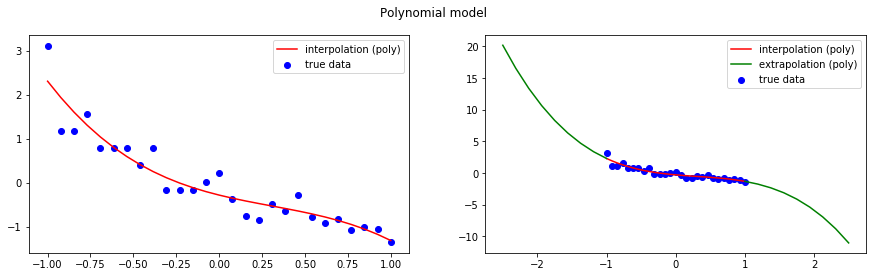

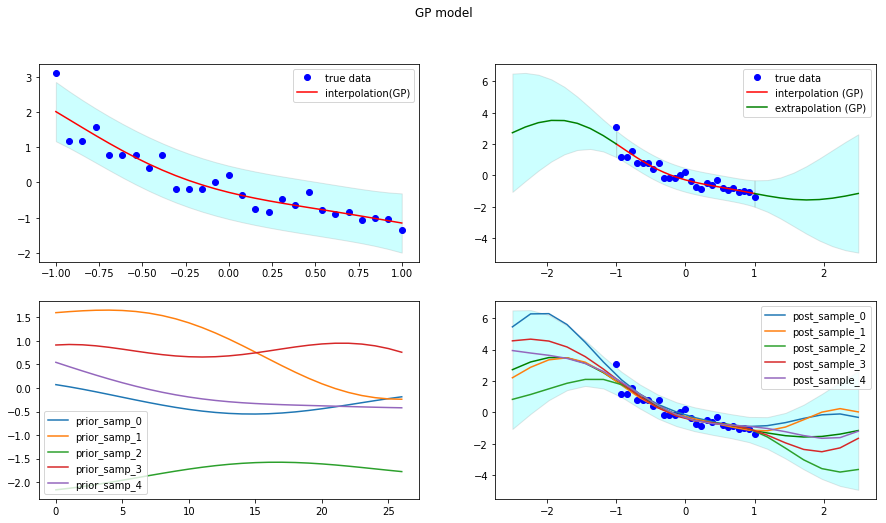

In [4]:
#---- Interpolation with Polynomial model
plt.figure(figsize=(15,4))
plt.suptitle('Polynomial model', fontsize=12)
plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color = 'blue', label="true data") 
plt.plot(x_train, lin_poly.predict(x_poly_train), color = 'red', label="interpolation (poly)") 
plt.legend()

#--- Extrapolation with Polynomial model
plt.subplot(1,2,2)
plt.scatter(x_train, y_train, color = 'blue', label="true data") 
plt.plot(x_train, lin_poly.predict(x_poly_train), color = 'red', label="interpolation (poly)") 
plt.plot(x_test_left, lin_poly.predict(poly.fit_transform(x_test_left) ), color='green', label="extrapolation (poly)")
plt.plot(x_test_right, lin_poly.predict(poly.fit_transform(x_test_right) ), color='green')
plt.legend()

plt.figure(figsize=(15,8))
plt.suptitle('GP model', fontsize=12)

#--- Interpolation with GP model
plt.subplot(2,2,1)
plot_fit(x_train, y_train, y_gp, y_gp_std, 'bo', 'r-', 'true data', 'interpolation(GP)')

#--- Extrapolation with GP model
plt.subplot(2,2,2)
plot_fit(x_train, y_train, y_gp, y_gp_std, 'bo', 'r-', 'true data', 'interpolation (GP)')
plot_fit(x_test_left, None, y_gp_l, y_gp_std_l, 'bo', 'g-', '', 'extrapolation (GP)')
plot_fit(x_test_right, None, y_gp_r, y_gp_std_r, 'bo', 'g-', legend=False)

#---- Plot *prior* samples from GP model
plt.subplot(2,2,3)
x_samp = np.linspace(x_test_left[0], x_test_right[-1], 20)[:,None]
N_samp = 5
prior_samp = np.zeros((N_samp, x_train.shape[0]))
for i in np.arange(N_samp):
    prior_samp[i,:] = np.random.multivariate_normal(mean=np.zeros(x_train.shape[0]), cov=K)
    plt.plot(prior_samp[i,:], label='prior_samp_'+str(i))
plt.legend()

#--- Plot *posterior* samples from GP model
plt.subplot(2,2,4)
plot_fit(x_samp, None,  m.predict(x_samp)[0], m.predict(x_samp)[1], 'bo', 'g-','','', legend=False)
plt.scatter(x_train, y_train, color = 'blue') 
f_samp = m.posterior_samples_f(x_samp, 5)
for i in range(f_samp.shape[2]):
    plt.plot(x_samp, f_samp[:,:,i], label='post_sample_' + str(i))
plt.legend()

#### Observations:   

- The GP model gives uncertainty in the fit/predictions, shown as shaded area.  
- The GP model is, naturally, more uncertain in extrapolations.
- The GP model, away from the training data, reverts to its prior (here implicitly zero, that can be changed) rather than confidently giving unrealistic predictions.
- The GP model can be investigated before training (prior samples) or after training (posterior samples). The samples tell us "what sort of functions does that model consider".

# Part 2: GPs as infinite dimensional Gaussian distributions 

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.

## Intuition by sampling and plotting Gaussians

Let's first define some plotting functions that we'll use later. 

In [5]:
def gen_Gaussian_samples(mu, sigma, N=200):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    """
    D = mu.shape[0]
    samples = np.zeros((N,D))
    for i in np.arange(N):
        samples[i,:] = np.random.multivariate_normal(mean=mu, cov=sigma)
    return samples.copy()


def gen_plot_Gaussian_samples(mu, sigma,N=1000):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    and plot the samples as they're generated
    """
    for i in np.arange(N):
        sample = np.random.multivariate_normal(mean=mu, cov=sigma)
        plt.plot(sample[0],sample[1], '.',color='r',alpha=0.6)
    plt.grid()


def plot_Gaussian_contours(x,y,mu,sigma,N=100):
    """
    Plot contours of a 2D multivariate Gaussian based on N points. Given points x and y are 
    given for the limits of the contours
    """
    X, Y = np.meshgrid(np.linspace(x.min()-0.3,x.max()+0.3,100), np.linspace(y.min()-0.3,y.max()+0.3,N))
    rv = multivariate_normal(mu, sigma)
    Z = rv.pdf(np.dstack((X,Y)))
    plt.contour(X,Y,Z)
    plt.xlabel('x_1')
    plt.ylabel('x_2')

def plot_sample_dimensions(samples, colors=None, markers=None, ms=10):
    """
    Given a set of samples from a bivariate Gaussian, plot them, but instead of plotting them
    x1 vs x2, plot them as [x1 x2] vs ['1', '2']
    """
    N = samples.shape[0]
    D = samples.shape[1]
    
    t=np.array(range(1,D+1))

    for i in np.arange(N):
        if colors is None and markers is None:
            plt.plot(t,samples[i,:], '-o',ms=ms)
        elif colors is None:
            plt.plot(t,samples[i,:], '-o',marker=markers[i],ms=ms)
        elif markers is None:
            plt.plot(t,samples[i,:], '-o',color=colors[i],ms=ms)
        else:
            plt.plot(t,samples[i,:], '-o',color=colors[i],marker=markers[i],ms=ms)
    plt.grid()
    plt.xlim([0.8,t[-1]+0.2])
    plt.ylim([samples.min()-0.3, samples.max()+0.3])
    plt.xlabel('d = {' + str(t) + '}')
    plt.ylabel('[x_d]')
    plt.gca().set_title(str(N) + ' samples from a bivariate Gaussian')


def set_limits(samples):
    plt.xlim([samples[:,0].min()-0.3, samples[:,0].max()+0.3])
    plt.ylim([samples[:,1].min()-0.3, samples[:,1].max()+0.3])


Test the two different ways of plotting a bivariate Gaussian.

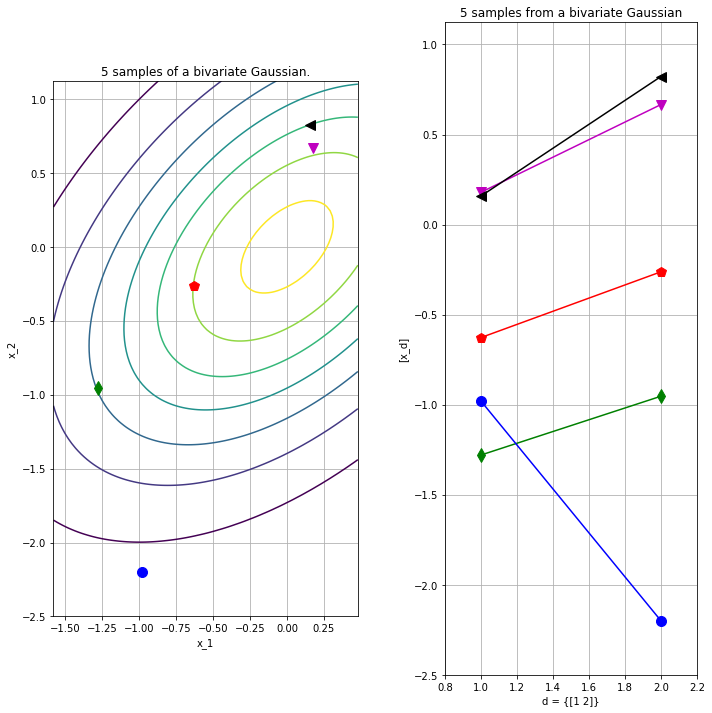

In [6]:
colors = ['r','g','b','m','k']
markers = ['p','d','o','v','<']

N=5 # Number of samples
mu = np.array([0,0])  # Mean of the 2D Gaussian
sigma = np.array([[1, 0.5], [0.5, 1]]); # covariance of the Gaussian


# Generate samples
samples = gen_Gaussian_samples(mu,sigma,N) 


f=figure(figsize=(12,12)); 
ax1=plt.subplot(1, 2, 1,autoscale_on=False, aspect='equal')
set_limits(samples)
plot_Gaussian_contours(samples[:,0],samples[:,1],mu,sigma)

# Plot samples
for i in np.arange(N):
    plt.plot(samples[i,0],samples[i,1], 'o', color=colors[i], marker=markers[i],ms=10)
plt.grid()
plt.gca().set_title(str(N) + ' samples of a bivariate Gaussian.')

ax2=plt.subplot(1, 2, 2,autoscale_on=False, aspect='equal')
plot_sample_dimensions(samples=samples, colors=colors, markers=markers)
#ax2.set(autoscale_on=False, aspect='equal')

Repeat as before, but now we'll plot many samples from two kinds of Gaussians: one which with strongly correlated dimensions and one with weak correlations

Text(0.5,1,'Stongly correlated Gaussian')

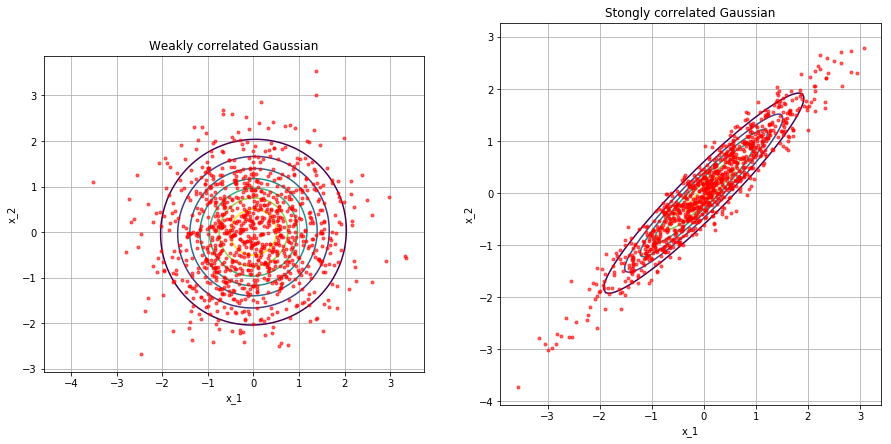

In [7]:
# Plot with contours. Compare a correlated vs almost uncorrelated Gaussian

sigmaUncor = np.array([[1, 0.02], [0.02, 1]]);
sigmaCor = np.array([[1, 0.95], [0.95, 1]]);

f=figure(figsize=(15,15)); 

ax=plt.subplot(1, 2, 1); ax.set_aspect('equal')
samplesUncor=gen_Gaussian_samples(mu,sigmaUncor)
plot_Gaussian_contours(samplesUncor[:,0],samplesUncor[:,1], mu, sigmaUncor)
gen_plot_Gaussian_samples(mu, sigmaUncor)
plt.gca().set_title('Weakly correlated Gaussian')

ax=plt.subplot(1, 2, 2); ax.set_aspect('equal')
samplesCor=gen_Gaussian_samples(mu,sigmaCor)
plot_Gaussian_contours(samplesCor[:,0],samplesCor[:,1], mu, sigmaCor)
gen_plot_Gaussian_samples(mu, sigmaCor)
plt.gca().set_title('Stongly correlated Gaussian')

(-4.5995273486559585, 3.1053517856856994)

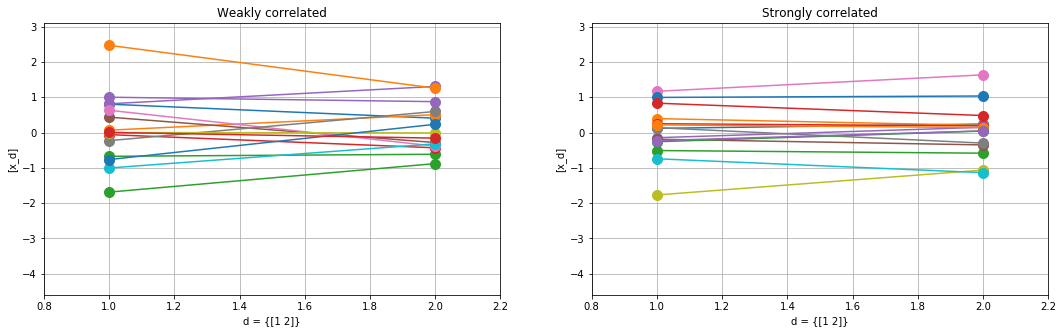

In [8]:
# But let's plot them as before dimension-wise...

f=figure(figsize=(18,5)); 
perm = np.random.permutation(samplesUncor.shape[0])[0::14]

ax1=plt.subplot(1, 2, 1); ax1.set_aspect('auto')
plot_sample_dimensions(samplesUncor[perm,:])
plt.gca().set_title('Weakly correlated')
ax2=plt.subplot(1, 2, 2,sharey=ax1); ax2.set_aspect('auto')
plot_sample_dimensions(samplesCor[perm,:])
plt.gca().set_title('Strongly correlated')
plt.ylim([samplesUncor.min()-0.3, samplesUncor.max()+0.3])

The strongly correlated Gaussian results in more "horizontal" lines in the dimension-wise plot.

More importantly, by using the dimension-wise plot, we are able to plot Gaussians which have more than two dimensions. Below we plot N samples from a D=8-dimensional Gaussian. Because I don't want to write down the full 8x8 covariance matrix, I define a "random" one through a mathematical procedure that is guaranteed to give me back a positive definite and symmetric matrix (i.e. a valid covariance). More on this later.

Text(0.5,1,'5 samples of a 8 dimensional Gaussian')

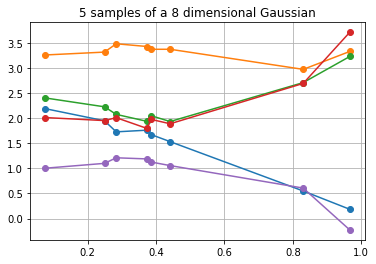

In [9]:
N=5
mu = np.array([0,0,0,0,0,0,0,0])
D = mu.shape[0]

# Generate random covariance matrix
tmp = np.sort(sp.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T) + 0.005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-o')
plt.grid()

plt.gca().set_title(str(N) + ' samples of a ' + str(D) + ' dimensional Gaussian')

Taking this even further, we can plot samples from a 200-dimensional Gaussian in the dimension-wise plot. 

Text(0.5,1,'5 samples of a 200 dimensional Gaussian')

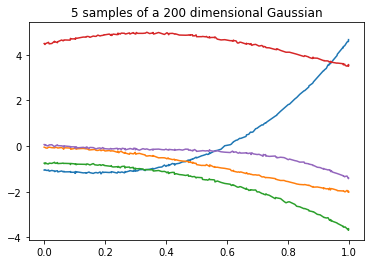

In [10]:
N=5
D=200
mu = np.zeros((D,1))[:,0]

# Generate random covariance matrix
tmp = np.sort(sp.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T)+ 0.0005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-')

plt.gca().set_title(str(N) + ' samples of a ' + str(D) + ' dimensional Gaussian')

We see that each sample now starts looking like a "smooth" curve. Therefore, we now have a clear intuition as to why a GP can be seen as an *infinite dimensional multivariate Gaussian* which is used as a *prior over functions*, since one sample from a GP is a function.

### Mean and covariance function

Similarly to how a D-dimensional Gaussian is parameterized by its mean vector and its covariance matrix, a GP is parameterized by a mean *function* and a covariance *function*. To explain this, we'll assume (without loss of generality) that the mean function is $\mu(x) = \mathbf{0}$. As for the covariance function, $k(x,x')$, it is a function that receives as input two locations $x,x'$ belonging to the input domain, i.e. $x,x' \in \mathcal{X}$, and returns the value of their co-variance.

In this way, if we have a *finite* set of input locations we can evaluate the covariance function at every pair of locations and obtain a covariance matrix $\mathbf{K}$. We write:
$$
\mathbf{K} = k(\mathbf{X}, \mathbf{X}),
$$
where $\mathbf{X}$ is the collection of training inputs.

More on covariance functions later. For the moment, think of them as kind of a black box.

Importantly, even if we assume that the input domain is inifinte, e.g. $\mathbb{R}$, we can get away with never having to perform infinite number of operations. This is because of the marginalization property of the Gaussian distribution. See below.

## Marginalization and conditioning properties of the Gaussian

### Joint

Let's start with a multivariate Gaussian. Assume that we have a random variable $\mathbf{f}$ which follows a multivariate Gaussian, and we partition its dimensions into two sets, $A,B$. Then, the joint distribution can be written as:
$$
p(\underbrace{f_1, f_2, \cdots, f_s}_{\mathbf{f}_A}, \underbrace{f_{s+1}, f_{s+2}, \cdots, f_N}_{\mathbf{f}_B}) \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}).
$$
with:
$$
\boldsymbol \mu = 
    \begin{bmatrix}
        \boldsymbol \mu_A \\
      \boldsymbol \mu_B
    \end{bmatrix}
  \; \; \text{and} \; \;
    \mathbf{K} = 
    \begin{bmatrix}
         \mathbf{K}_{A A} & \mathbf{K}_{A B} \\
         \mathbf{K}_{B A} & \mathbf{K}_{B B}
    \end{bmatrix}
$$

### Marginal

And the *marginal* distribution can be written as:

$$
p(\mathbf{f}_A, \mathbf{f}_B)  \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}). \text{ Then:} \\
p(\mathbf{f}_A)  = \int_{\mathbf{f}_B} p(\mathbf{f}_A, \mathbf{f}_B) \text{d} \mathbf{f}_B =
       \mathcal{N}(\boldsymbol \mu_A, \mathbf{K}_{A A}) %\\
% p(\mathbf{f}_B)  = \int_{\mathbf{f}_A} p(\mathbf{f}_A, \mathbf{f}_B) \text{d} \mathbf{f}_A = 
%        \mathcal{N}(\boldsymbol \mu_B,\mathbf{K}_{B B})
$$

The marginalization property means that the training data that have and any (potentially infinite in number) test data $f_*$ that we have not seen (yet), follow a (potentially infinite) Gaussian distribution with mean and covariance:

$$
  \boldsymbol \mu_{\infty} = 
    \begin{bmatrix}
      \boldsymbol \mu_{\!_\mathbf{X}} \\
      \cdots \\
      \cdots
    \end{bmatrix}
  \; \; \text{and} \; \;
    \mathbf{K}_{\infty} = 
    \begin{bmatrix}
      \mathbf{K}_{\!_\mathbf{X} \!_\mathbf{X}} & \cdots \\
      \cdots & \cdots
    \end{bmatrix}
$$

where $\mathbf{X}$ is training inputs and $\mathbf{K}_{XX}$ is the covariance matrix constructing by evaluating the covariance *function* at all given inputs. 

So, in the Gaussian process case (assuming 0 mean) we have a joint Gaussian distribution of the training and the (potentially infinite!) test data:

$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$

Here, $\mathbf{K}_\ast$ is the (cross)-covariance matrix obtained by evaluating the covariance function in pairs of training inputs $\mathbf{X}$ and test inputs $\mathbf{X_*}$, ie.

$$
\mathbf{K}_\ast = k(\mathbf{X}, \mathbf{X}_*) .
$$

Similarly:

$$
\mathbf{K}_{\ast\ast} = k(\mathbf{X}_*, \mathbf{X}_*) .
$$

### Conditional 

Interestingly, conditioning a multivariate Gaussian to obtain the posterior distribution also yields a Gaussian:
Again, if
$$
p(\mathbf{f}_A, \mathbf{f}_B)  \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}). \; \; \text{Then:} \\
p(\mathbf{f}_A | \mathbf{f}_B) = \mathcal{N}(\boldsymbol \mu_A + \mathbf{K}_{AB} \mathbf{K}^{-1}_{BB} (\mathbf{f}_B - \boldsymbol \mu_B), \mathbf{K}_{AA} - \mathbf{K}_{AB}\mathbf{K}_{BB}^{-1}\mathbf{K}_{BA})% \\
% p(\mathbf{f}_B | \mathbf{f}_A) = \mathcal{N}(\cdots, \cdots)
$$

In the GP context this can be used for inter/extrapolation. Assume that we have a function $f$ with input domain $\mathcal{X} = \mathbb{R}$ and we set a GP prior on $f$ (so, now we use $f$ to denote function evaluations, rather than random variables). Also assume that we have a training set $\mathbf{X} = [x_1, x_2, \dots x_N]$. Then, we can condition on the function ouputs evaluated on the training set in order to perform inference for the function value at *any* input location $x_* \in \mathbb{R}$. This conditioning means finding the GP posterior *process*:

$$
p(\mathbf{f_*} | \mathbf{f_1}, \cdots, \mathbf{f_N}) = 
p(f(x_*) | f(x_1), \cdots, f(x_N)) \\
         \sim \mathcal{N}(\mathbf{K}_*^\top \mathbf{K}^{-1} \mathbf{f}\; , \; \mathbf{K}_{*,*} - \mathbf{K}_*^\top \mathbf{K}^{-1} \mathbf{K}_*)
$$

Remember, the test inputs $\mathbf{X}_*$ appear in the above expression inside $\mathbf{K}_*$ and $\mathbf{K}_{**}$.

## Noise model

As is standard in probabilistic regression, we assume a noise model. We take:

$$
y = f(x) + \epsilon
$$

where:

$$
f \sim \mathcal{GP}(0, k(x,x'))
$$

and

$$
\epsilon \sim \mathcal{N}(0,\sigma^2 I) \; \; \; \; \; \; \; \; \; (1)
$$

where non-bold symbols now denote single elements from the training vectors.

The *covariance function* $k(x,x')$ is a function which takes as inputs pairs in the input domain and returns their co-variance. By denoting $k(\mathbf{X},\mathbf{X})$ we mean that we evaluate the covariance function in the whole training set, $\mathbf{X}$, and this gives us back a covariance matrix.

The assumption about Gaussian noise says that the *training data* $(x,y) \in (\mathbf{X}, \mathbf{Y})$ are related by a function $f$ whose output is then corrupted by Gaussian noise (i.e. we have noisy observations).
The above construction, gives us the following probabilities:
\begin{equation}
p(\mathbf{y}|\mathbf{f}) = \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}) 
\end{equation}

$$
p(\mathbf{f}|\mathbf{x}) = \mathcal{N}(\mathbf{f}|\mathbf{0}, K_{ff}) = (2 \pi)^{n/2} |K_{ff}|^{-1/2} \exp\left( -\frac{1}{2} \mathbf{f}^T K_{ff} \mathbf{f} \right) \text{where:} K_{ff} = k(\mathbf{x},\mathbf{x}) \; \; \; \; (2)
$$

$$
p(\mathbf{y}|\mathbf{x}) = \int p(\mathbf{y}|\mathbf{f})p(\mathbf{f}|\mathbf{x}) d\mathbf{f} = \mathcal{N}(\mathbf{y}|\mathbf{0},K_{ff}+\sigma^{2} \mathbf{I}) \; \; \; \; (3)
$$
where the last quantity is called the *marginal likelihood* and is tractable because of our choice for noise $\epsilon$ which is normally distributed.



## Predictions
Now, for a test point $x_*$ we want to compute its output on the observed space, i.e. we want to compute $y_*$. Building on the noise model and the previously shown expressions, the posterior for the test outputs is given by:

$$
\mathbf{y}^* | \mathbf{y}, \mathbf{x}, \mathbf{x_*} \sim \mathcal{N}(\boldsymbol \mu_{\text{pred}},\mathbf{K}_{\text{pred}}) \; \; \; \; (4)
$$
with  
$$
\boldsymbol \mu_{\text{pred}} = \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{y}
$$
and 
$$
\mathbf{K}_{\text{pred}} = \mathbf{K}_{*,*} - \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_*.
$$

# Covariance functions, aka kernels

We saw above their role for creating covariance matrices from training inputs, thereby allowing us to work with finite when the domain is potentially infinite.

We'll see below that the covariance function is what encodes our assumption about the GP. By selecting a covariance function, we are making implicit assumptions about the shape of the function we wish to encode with the GP, for example how smooth it is.

Even if the covariance function has a parametric form, combined with the GP it gives us a nonparametric model. In other words, the covariance function is specifying the general properties of the GP function we wish to encode, and not a specific parametric form for it.

Below we define two very common covariance functions: The RBF (also known as Exponentiated Quadratic or Gaussian kernel) which is differentiable infinitely many times (hence, very smooth), and the linear one:
$$
k_{RBF}(\mathbf{x}_{i,:},\mathbf{x}_{j,:}) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$
where $Q$ denotes the dimensionality of the input space. Its parameters are: the *lengthscale*, $\ell$ and the variance $\sigma^2$.

$$
k_{lin}(\mathbf{x}_{i,:},\mathbf{x}_{j,:}) = \sigma^2 \mathbf{x}_{i,:}^T \mathbf{x}_{j,:}
$$
Its parameters is the variance $\sigma^2$.

Below, we will implement and investigate them.

## Defining covariance function forms

In [11]:
def cov_linear(x,x2=None,theta=1):
        if x2 is None:
            return np.dot(x, x.T)*theta
        else:
            return np.dot(x, x2.T)*theta
    
        
def cov_RBF(x, x2=None, theta=np.array([1,1])):        
        """
        Compute the Euclidean distance between each row of X and X2, or between
        each pair of rows of X if X2 is None and feed it to the kernel.
        """
        variance = theta[0]
        lengthscale = theta[1]
        if x2 is None:
            xsq = np.sum(np.square(x),1)
            r2 = -2.*np.dot(x,x.T) + (xsq[:,None] + xsq[None,:])
            r = np.sqrt(r2)/lengthscale
        else:
            x1sq = np.sum(np.square(x),1)
            x2sq = np.sum(np.square(x2),1)
            r2 = -2.*np.dot(x, x2.T) + x1sq[:,None] + x2sq[None,:]
            r = np.sqrt(r2)/lengthscale

        return variance * np.exp(-0.5 * r**2)


## Experimenting with covariance function parameters

Text(0.5,0.98,'RBF (left) and Linear (right) cov. matrices created with different parameters')

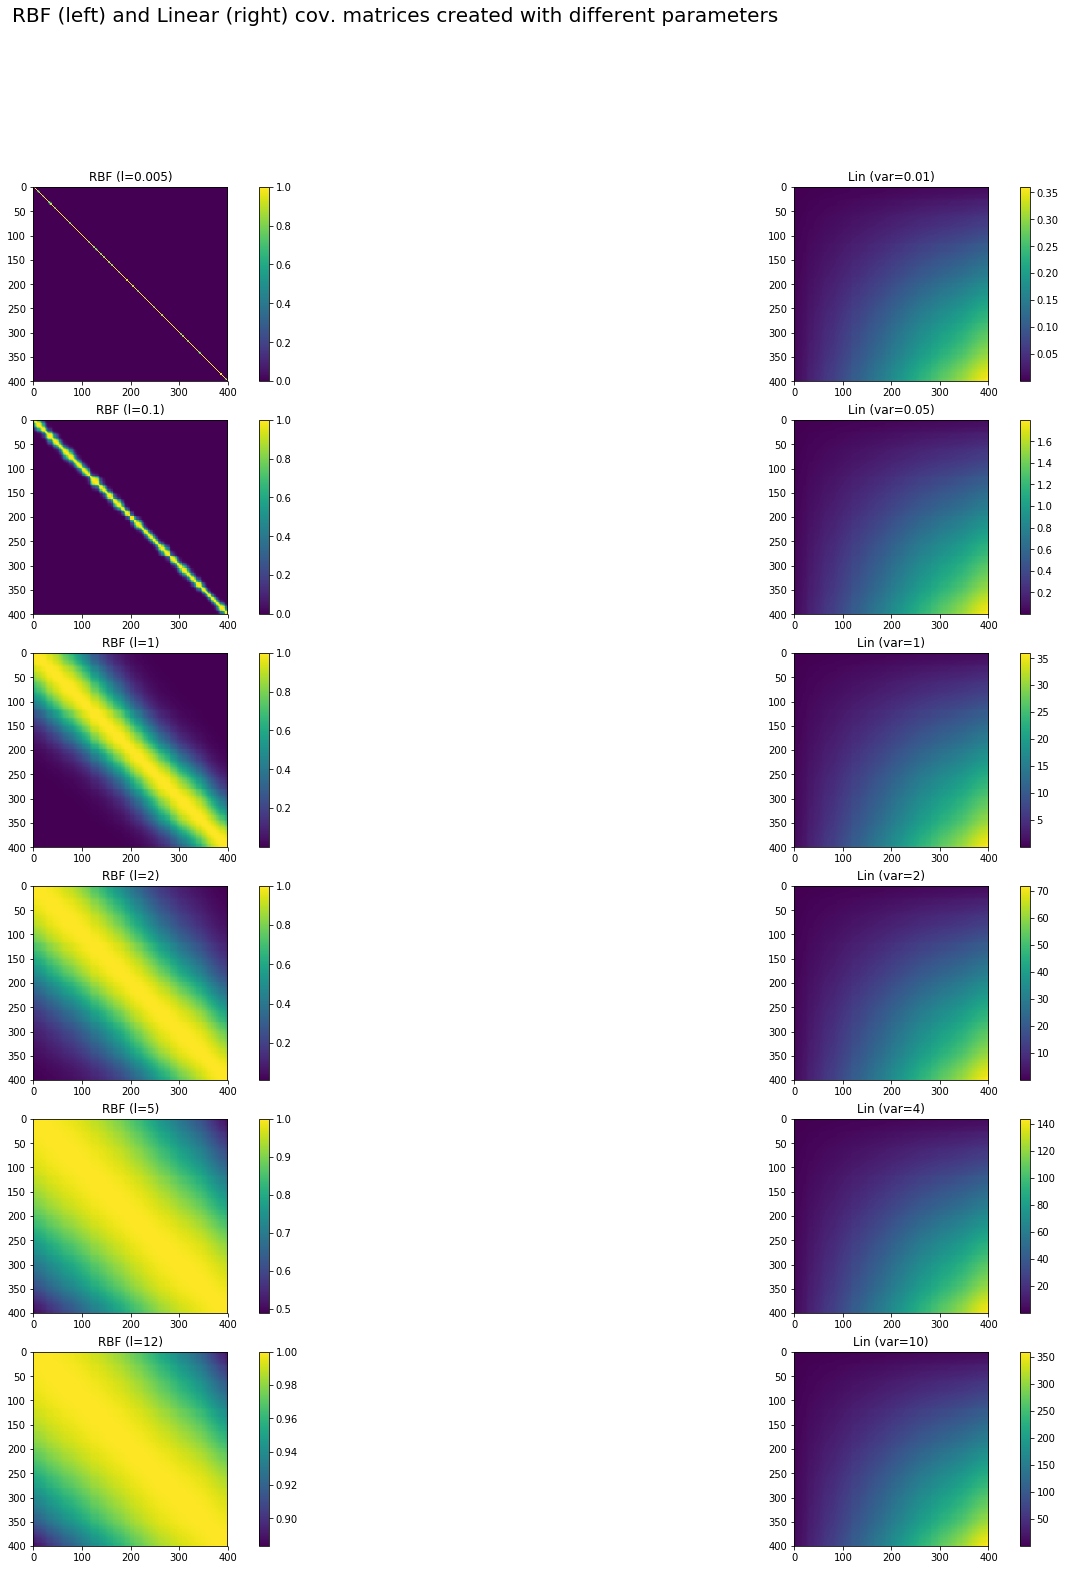

In [12]:
X = np.sort(np.random.rand(400, 1) * 6 , axis=0)

params_linear = [0.01, 0.05, 1, 2, 4, 10]
params_rbf    = [0.005, 0.1, 1, 2, 5, 12]
K = len(params_linear)

plt.figure(figsize=(25,25))
j=1
for i in range(K):
    plt.subplot(K,2,j)
    K_rbf = cov_RBF(X,X,theta=np.array([1,params_rbf[i]]))
    plt.imshow(K_rbf)
    plt.colorbar()
    plt.gca().set_title('RBF (l=' + str(params_rbf[i]) + ')')
    
    plt.subplot(K,2,j+1)
    K_lin = cov_linear(X,X,theta=params_linear[i])
    plt.imshow(K_lin)
    plt.colorbar()
    plt.gca().set_title('Lin (var=' + str(params_linear[i]) + ')')
    
    j+=2
    
plt.suptitle('RBF (left) and Linear (right) cov. matrices created with different parameters', fontsize=20)

## Sampling GP instances from covariance functions


Given hyperparameters l, we plot the resulting cov. matrix and samples from a GP with this cov. function.

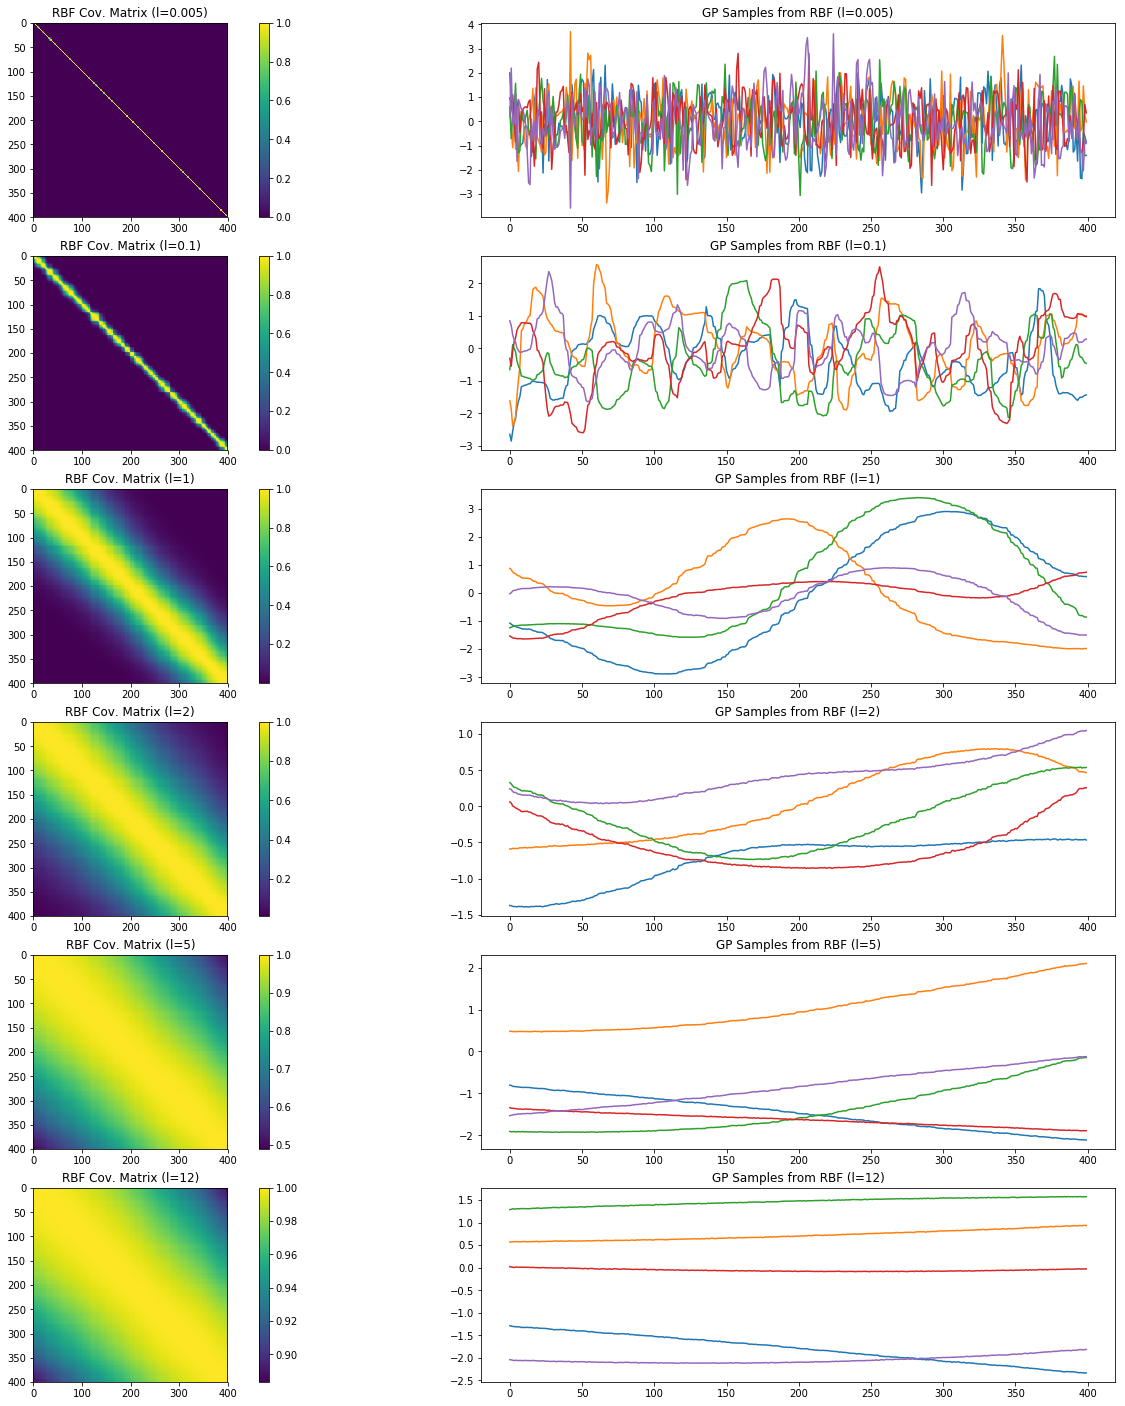

In [13]:
num_samples=5
plt.figure(figsize=(25,25))
j=1
for i in range(K):
    plt.subplot(K,2,j)
    K_rbf = cov_RBF(X,X,theta=np.array([1,params_rbf[i]]))
    plt.imshow(K_rbf)
    plt.colorbar()
    plt.gca().set_title('RBF Cov. Matrix (l=' + str(params_rbf[i]) + ')')
    
    plt.subplot(K,2,j+1)
    # Assume a GP with zero mean
    mu=np.zeros((1,K_rbf.shape[0]))[0,:]
    for s in range(num_samples):
        # Jitter is a small noise addition to the diagonal to ensure positive definiteness
        jitter = 1e-5*np.eye(K_rbf.shape[0])
        sample = np.random.multivariate_normal(mean=mu, cov=K_rbf+jitter)
        plt.plot(sample)
    plt.gca().set_title('GP Samples from RBF (l=' + str(params_rbf[i]) + ')')
    j+=2
    


As we see, short lengthscales give very small correlations in the cov. matrix, resulting in very non-smooth functions. Conversely, long lengthscales result in very strongly correlated matrices and, therefore, very smooth functions. 

### Other covariance functions

As we saw, each covariance function can be parameterezed and (as we'll see next) adapted to the data. It's important, however, to use a reasonable cov. function to begin with, if we have some knowledge about our data. Importantly, by doing so we make our assumptions about our modelling approach explicit, which is a good principle in Bayesian statistics.

There are other covariance functions apart from the linear and the RBF. There is a very good GPy tutorial on this.

We can get a quick taste:

Text(0.5,0.98,'Cov. function form (left) and Sample cov. matrix (right)')

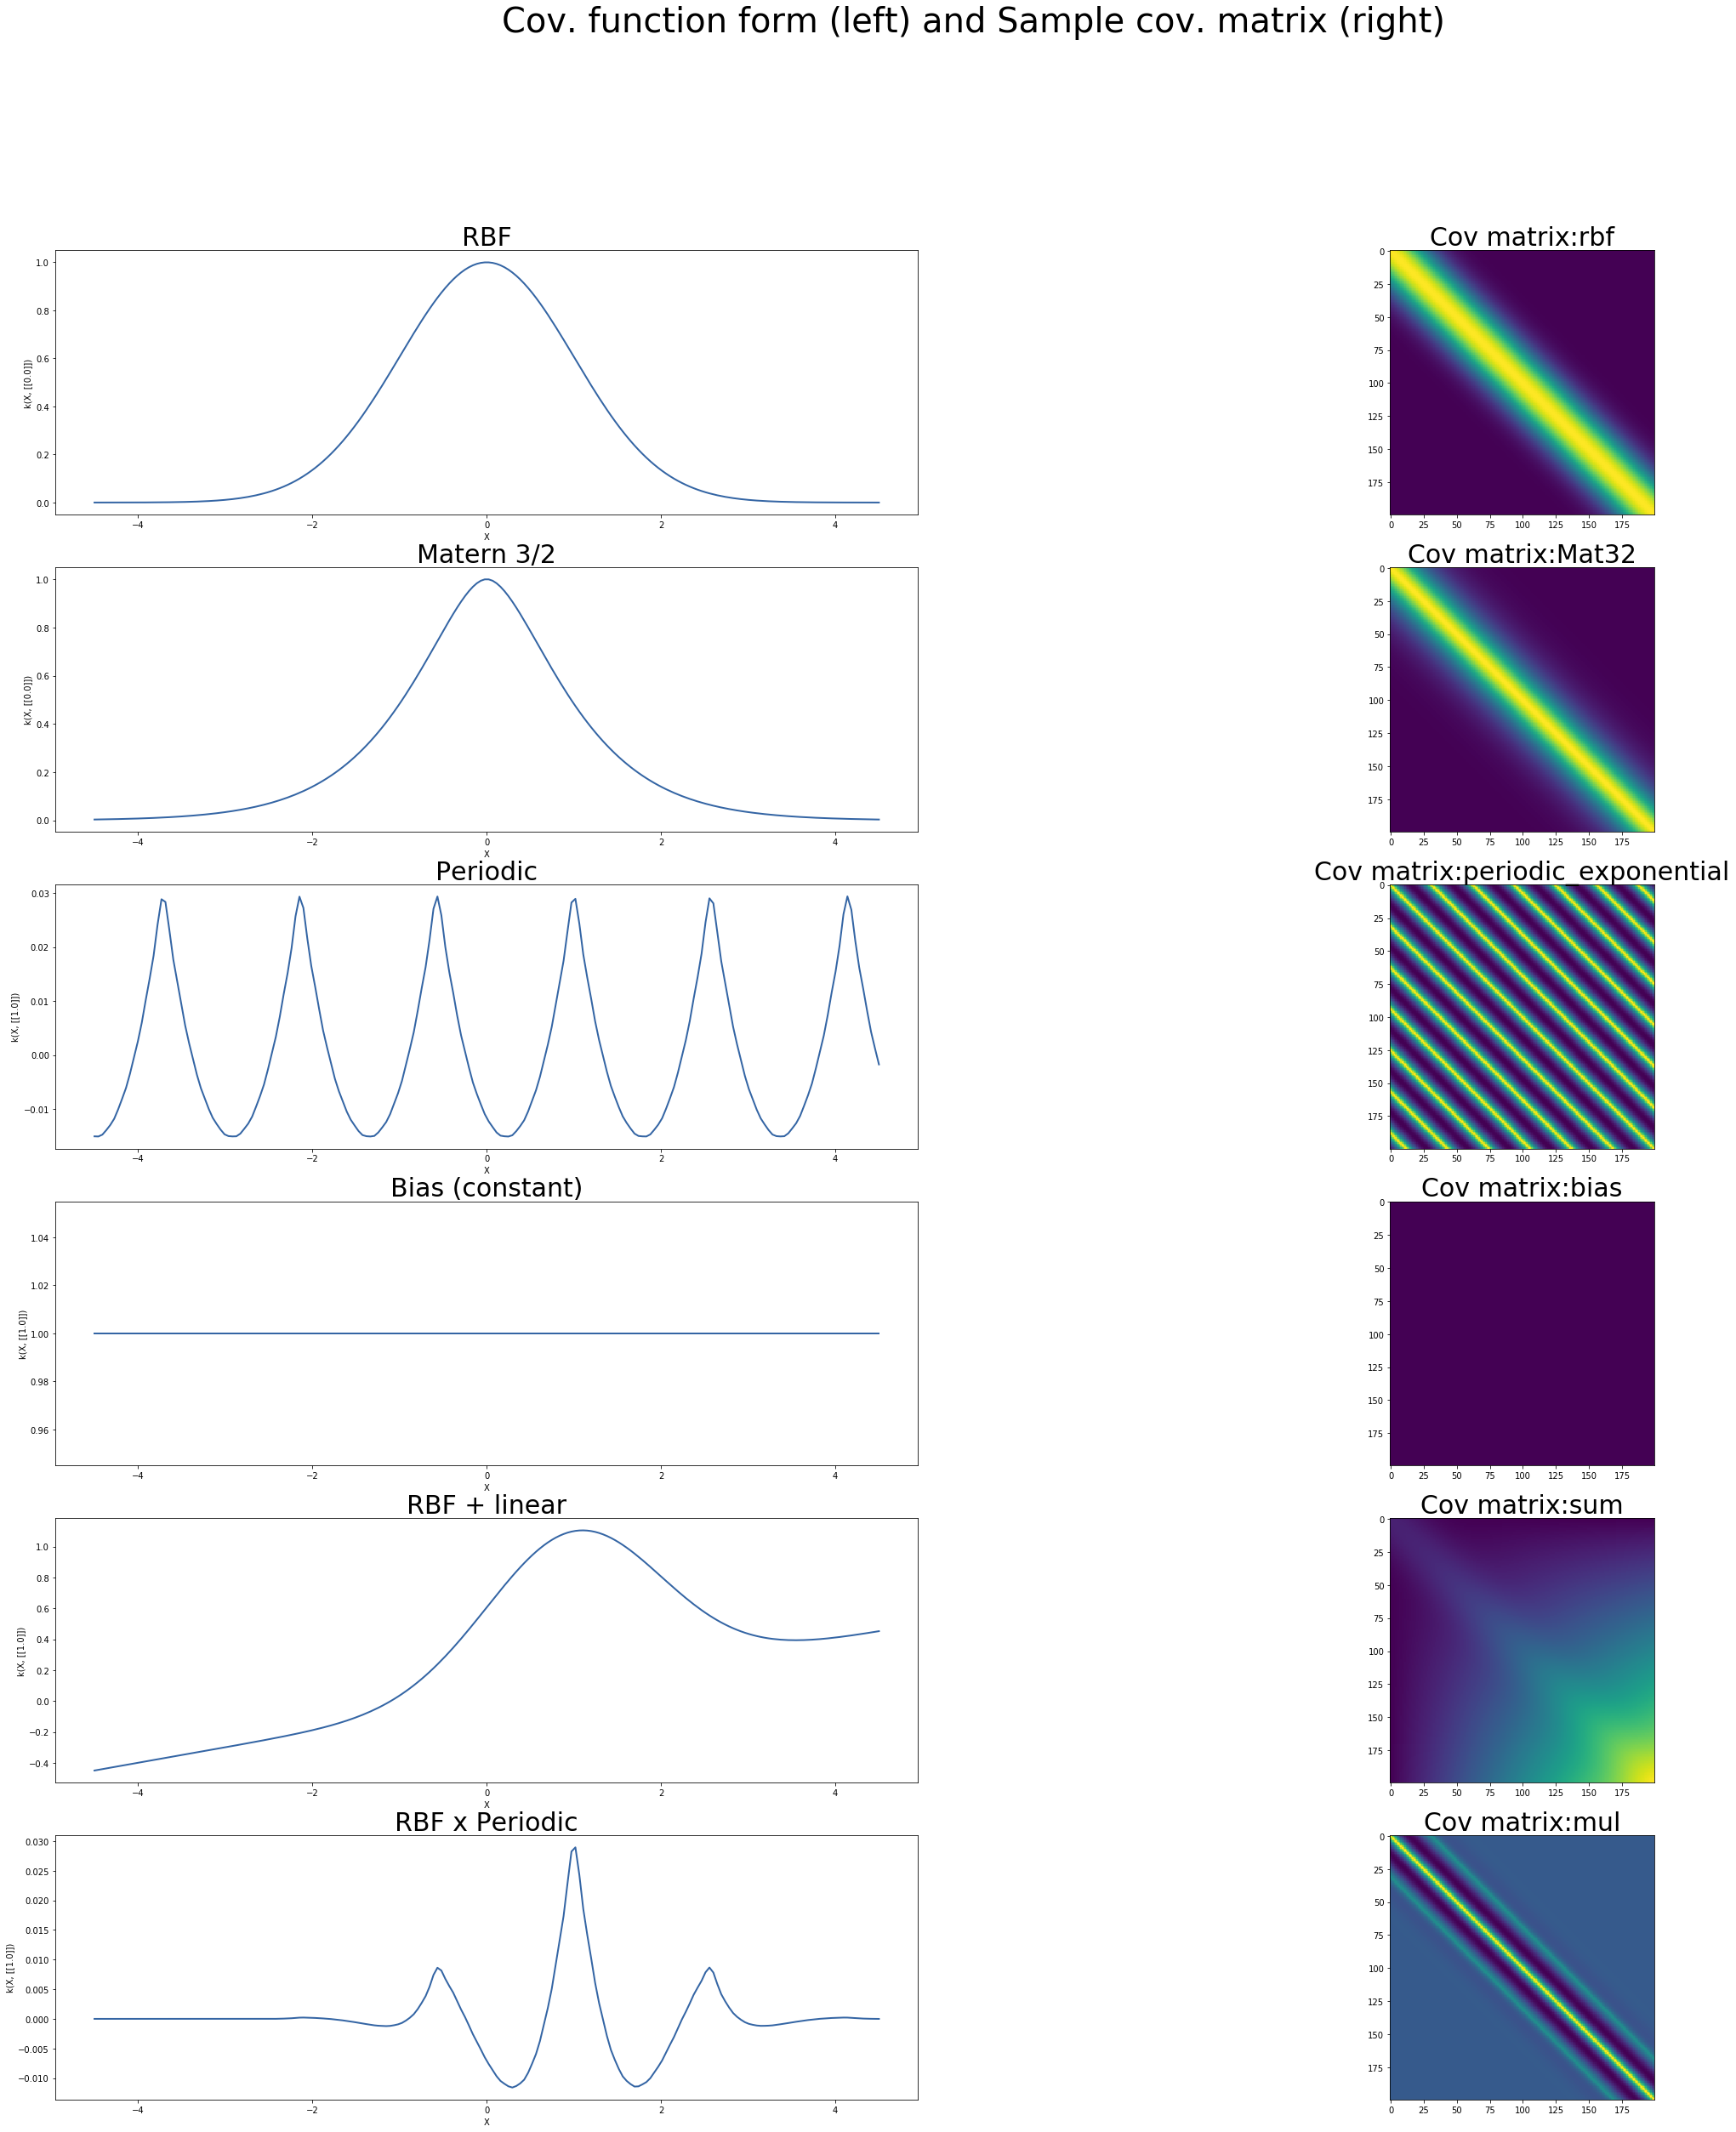

In [14]:
import GPy

Q=1
x_tmp = np.linspace(0,10,200)[:,None]

plt.figure(figsize=(40,40))
i=1
plt.subplot(6,2,i); i+=1
kern = GPy.kern.RBF(Q)
kern.plot(ax=gca());  plt.gca().set_title('RBF', fontsize=30); 
plt.subplot(6,2,i); i+=1
plt.imshow(kern.K(x_tmp)); plt.gca().set_title('Cov matrix:' + kern.name, fontsize=30)
plt.subplot(6,2,i); i+=1

kern = GPy.kern.Matern32(Q)
kern.plot(ax=gca()); plt.gca().set_title('Matern 3/2', fontsize=30);
plt.subplot(6,2,i); i+=1
plt.imshow(kern.K(x_tmp)); plt.gca().set_title('Cov matrix:' + kern.name, fontsize=30)
plt.subplot(6,2,i); i+=1

kern = GPy.kern.PeriodicExponential(Q,period=np.pi/2)
kern.plot(ax=gca()); plt.gca().set_title('Periodic', fontsize=30);
plt.subplot(6,2,i); i+=1
plt.imshow(kern.K(x_tmp)); plt.gca().set_title('Cov matrix:' + kern.name, fontsize=30)
plt.subplot(6,2,i); i+=1

kern = GPy.kern.Bias(Q)
kern.plot(ax=gca()); plt.gca().set_title('Bias (constant)', fontsize=30);
plt.subplot(6,2,i); i+=1
plt.imshow(kern.K(x_tmp)); plt.gca().set_title('Cov matrix:' + kern.name, fontsize=30)
plt.subplot(6,2,i); i+=1


# We can even add kernels and get a new one...
kern = GPy.kern.RBF(Q) + GPy.kern.Linear(Q,variances=0.1)
kern.plot(ax=gca()); plt.gca().set_title('RBF + linear', fontsize=30)
plt.subplot(6,2,i); i+=1
plt.imshow(kern.K(x_tmp)); plt.gca().set_title('Cov matrix:' + kern.name, fontsize=30)
plt.subplot(6,2,i); i+=1


# ...or even multiply them!
kern = GPy.kern.RBF(Q) * GPy.kern.PeriodicExponential(Q,period=np.pi/2)
kern.plot(ax=gca()); plt.gca().set_title('RBF x Periodic', fontsize=30)
plt.subplot(6,2,i); i+=1
plt.imshow(kern.K(x_tmp)); plt.gca().set_title('Cov matrix:' + kern.name, fontsize=30)

plt.suptitle('Cov. function form (left) and Sample cov. matrix (right)', fontsize=40)

# Part 3:  "Full" GP Implementation!

Let's finally implement our GP framework.


In [15]:
class CovFunctions(object):
    """
    A wrapper for covariance functions which is compatible with the GP class.
    """
    def __init__(self, covType, theta):
        self.covType = covType
        self.theta = theta
        if covType == 'linear':
            self.compute = self.linear
        elif covType == 'RBF':
            self.compute = self.RBF
    
    def set_theta(self, theta):
        self.theta = theta
    
    def get_theta(self):
        return self.theta
    
    def linear(self, x,x2=None):
        return cov_linear(x,x2,self.theta)
    
    def RBF(self, x, x2=None):
        return cov_RBF(x,x2,self.theta)


class GP(object):
    def __init__(self, X, Y, sigma2, covType, theta):
        self.X = X
        self.Y = Y
        self.N = self.X.shape[0]
        self.sigma2 = sigma2
        self.kern = CovFunctions(covType, theta)
        self.K = self.kern.compute(X)
        # Force computations
        self.update_stats()
    
    def get_params(self):
        return np.hstack((self.sigma2, self.kern.get_theta()))
    
    def set_params(self, params):
        self.sigma2 = params[0]
        self.kern.set_theta(params[1:])
    
    def update_stats(self):
        self.K = self.kern.compute(self.X)
        self.Kinv = np.linalg.inv(self.K+self.sigma2*np.eye(self.N))
        self.logdet = np.log(np.linalg.det(self.K+self.sigma2*np.eye(self.N)))
        self.KinvY = np.dot(self.Kinv, self.Y)
        # Equivalent to: np.trace(np.dot(self.Y, self.KinvY.T))
        self.YKinvY = (self.Y*self.KinvY).sum()
    
    def likelihood(self):
        """ 
        That's actually the logarithm of equation (3)
        Since logarithm is a convex function, maximum likelihood and maximum log likelihood wrt parameters
        would yield the same solutuion, but logarithm is better to manage mathematically and
        numerically.
        """
        return -0.5*(self.N*np.log(2*np.pi) + self.logdet + self.YKinvY)
    
    def posterior(self, x_star):
        """
        Implements equation (4)
        """
        self.update_stats()
        K_starstar = self.kern.compute(x_star, x_star)
        K_star = self.kern.compute(self.X, x_star)
        KinvK_star = np.dot(self.Kinv, K_star)
        mu_pred = np.dot(KinvK_star.T, self.Y)
        K_pred = K_starstar - np.dot(KinvK_star.T, K_star)
        return mu_pred, K_pred
    
    def objective(self,params):
        self.set_params(params)
        self.update_stats()
        return -self.likelihood()


## Testing the framework:

We'll create some sample 1D data as a draw from a GP with RBF covariance and lengthscale = 0.85. Next, we normalize the data and keep some for testing. We then plot the data.

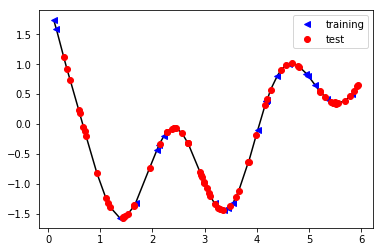

In [16]:
N=22 # number of training points
Nstar = 70 # number of test points

# create toy data
X = np.sort(np.random.rand(N+Nstar, 1) * 6 , axis=0)

K_rbf = cov_RBF(X,X,theta=np.array([1,0.85]))
mu=np.zeros((1,K_rbf.shape[0]))[0,:]
jitter = 1e-5*np.eye(K_rbf.shape[0])
Y = np.random.multivariate_normal(mean=mu, cov=K_rbf+jitter)[:,None]
#Y = np.sin(X*2) + np.random.randn(*X.shape) * 0.008

# split data into training and test set
perm = np.random.permutation(X.shape[0])
Xtr = X[np.sort(perm[0:N],axis=0),:]
Ytr = Y[np.sort(perm[0:N],axis=0),]
X_star = X[np.sort(perm[N:N+Nstar],axis=0),:]
Y_star = Y[np.sort(perm[N:N+Nstar],axis=0),:]

# Normalize data to be 0 mean and 1 std
Ymean = Ytr.mean()
Ystd = Ytr.std()
Ytr-=Ymean
Ytr/=Ystd
Y_star -= Ymean
Y_star /= Ystd

# plot data
plt.plot(X,(Y-Ymean)/Ystd, 'k-')
plt.plot(Xtr,Ytr, 'b<',label='training')
plt.plot(X_star,Y_star, 'ro',label='test')
plt.legend()

Now we'll define two GP models, one with linear and one with RBF cov. function. We'll use them to predict the training and the test data.

Text(0.5,1,'RBF, test')

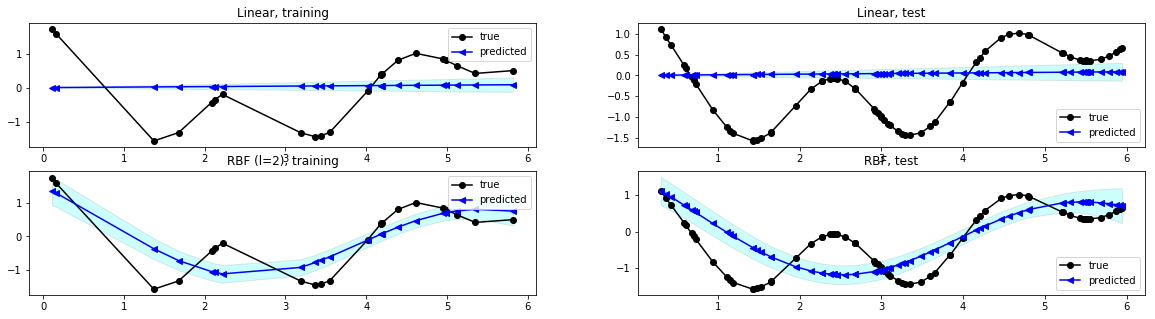

In [17]:
# Define GP models with initial parameters
g_lin = GP(Xtr, Ytr, 0.1, 'linear', 2)
g_rbf = GP(Xtr, Ytr, 0.1, 'RBF', np.array([1,2]))

# Get the posterior of the two GPs on the *training* data
mu_lin_tr,var_lin_tr = g_lin.posterior(Xtr)
mu_rbf_tr,var_rbf_tr = g_rbf.posterior(Xtr)

# Get the posterior of the two GPs on the *test* data
mu_lin_star,var_lin_star = g_lin.posterior(X_star)
mu_rbf_star,var_rbf_star = g_rbf.posterior(X_star)

# Plot the fit of the two GPs on the training and test data
f=figure(figsize=(20,5))
ax=plt.subplot(2, 2, 1); ax.set_aspect('auto')
plot_fit(Xtr, Ytr, mu_lin_tr, np.diag(var_lin_tr)[:,None])
plt.gca().set_title('Linear, training')

ax=plt.subplot(2, 2, 2); ax.set_aspect('auto')
plot_fit(X_star, Y_star, mu_lin_star, np.diag(var_lin_star)[:,None])
plt.gca().set_title('Linear, test')

ax=plt.subplot(2, 2, 3); ax.set_aspect('auto')
plot_fit(Xtr, Ytr, mu_rbf_tr, np.diag(var_rbf_tr)[:,None])
plt.gca().set_title('RBF (l=' +  str(g_rbf.kern.get_theta()[1]) + '), training')

ax=plt.subplot(2, 2, 4); ax.set_aspect('auto')
plot_fit(X_star, Y_star, mu_rbf_star, np.diag(var_rbf_star)[:,None])
plt.gca().set_title('RBF, test')


Even if we did not optimize the GPs, we see that both do a reasonably good job in fitting the data. This is because the GP is a nonparametric model, in the sense that the data itself act as additional (constant) parameters. Indeed, you can see that the posterior GP is given by an equation where the training data appear inside.

Let's convince ourselves that there is actually something to learn in the GP to get an even better fit. In the folllowing, we'll test the fit of the RBF kernel for various selections of the lengthscale.

Remember that the true one generating the data is 0.85, but we'd expect to find it as the best only if we have infinite data. Otherwise, something close to it is also expected.

In the next plot we show the fit for each lengthscale, and the Likelihood achieved by it.

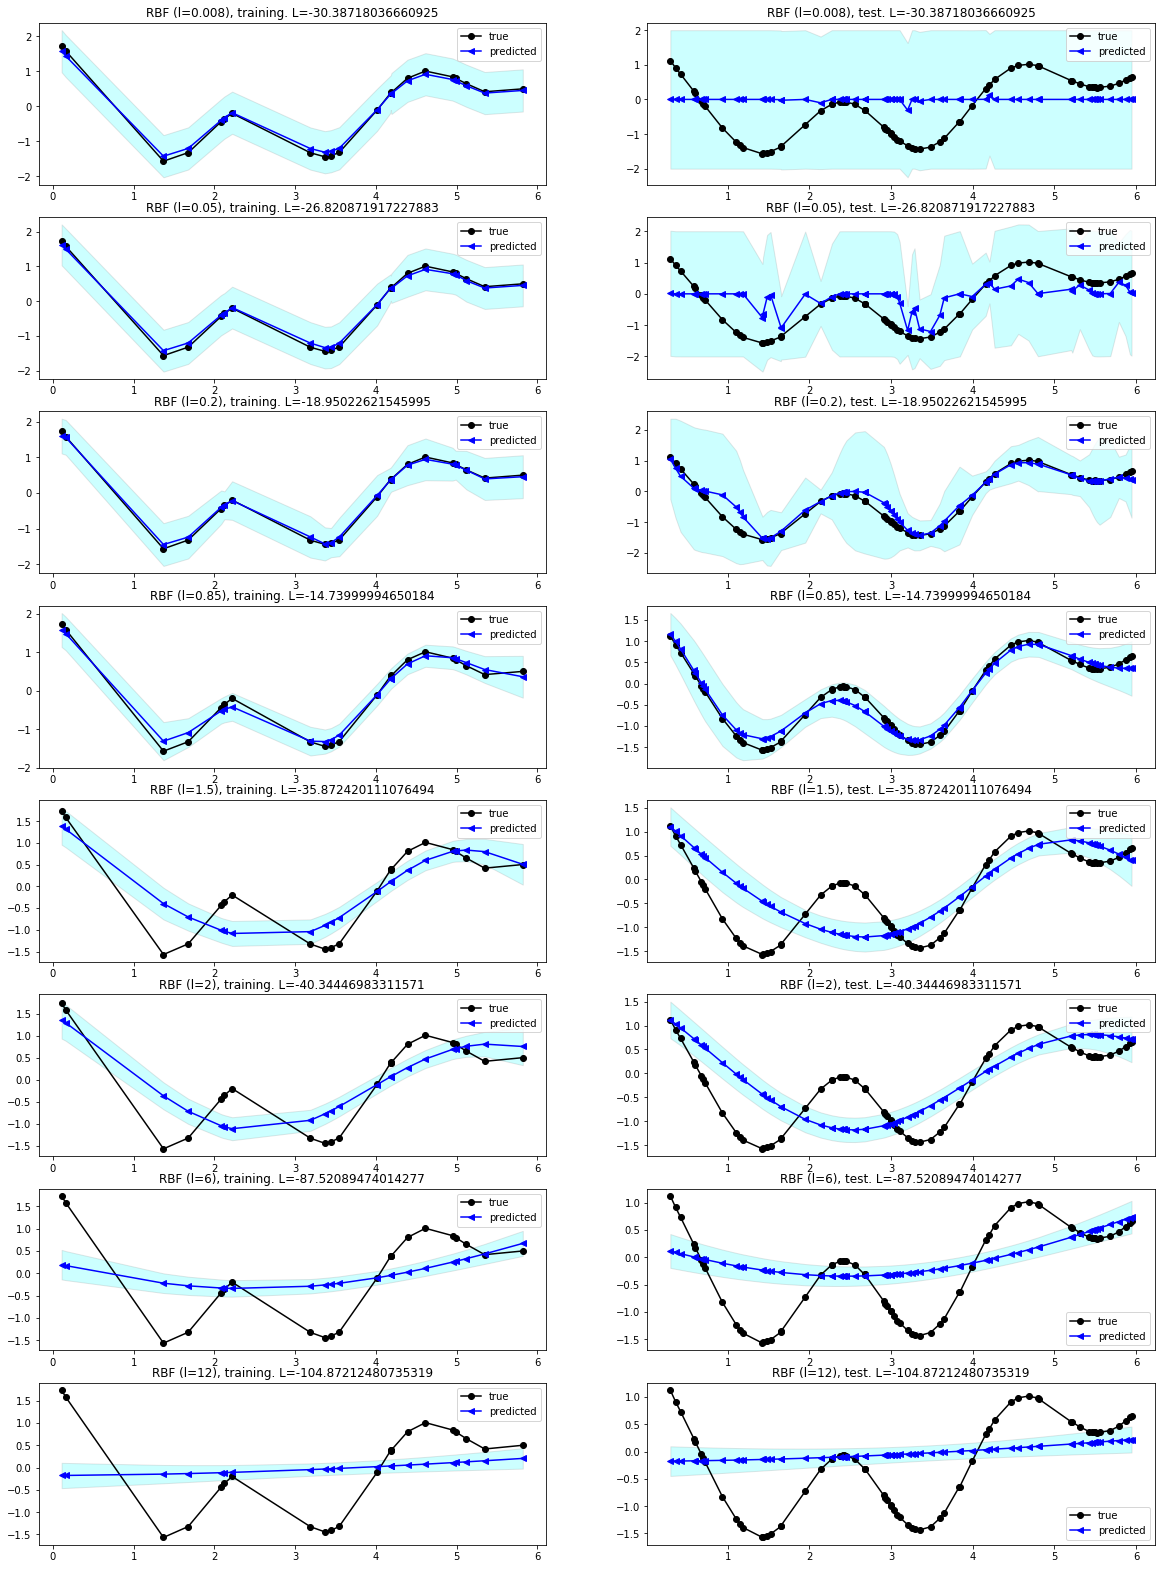

In [18]:
f=figure(figsize=(20,28)) 
i = 1
# Following array holds different lengthscales to test one by one
test_l=[0.008, 0.05, 0.2, 0.85, 1.5, 2, 6, 12]
for l in test_l:
    g_rbf = GP(Xtr, Ytr, 0.1, 'RBF', np.array([1,l]))
    mu_rbf_tr,var_rbf_tr = g_rbf.posterior(Xtr)
    mu_rbf_star,var_rbf_star = g_rbf.posterior(X_star)

    ax=plt.subplot(len(test_l), 2,i); ax.set_aspect('auto')
    plot_fit(Xtr, Ytr, mu_rbf_tr, np.diag(var_rbf_tr)[:,None])
    ll = g_rbf.likelihood()
    plt.gca().set_title('RBF (l=' +  str(g_rbf.kern.get_theta()[1]) + '), training. L=' + str(ll) )

    ax=plt.subplot(len(test_l), 2, i+1); ax.set_aspect('auto')
    plot_fit(X_star, Y_star, mu_rbf_star, np.diag(var_rbf_star)[:,None])
    ll = g_rbf.likelihood()
    plt.gca().set_title('RBF (l=' +  str(g_rbf.kern.get_theta()[1]) + '), test. L=' + str(ll) )
    i+=2



### Fitting and Overfitting

We see that very short lenthscales give more "wiggly" functions, which are capable of interpolating perfectly between the training points. However, such an overfitted model is biased to be more "surprised" by anything else other than the exact same training data... hence performing poorly in the test set.

On the other hand, high lengthscales give very flat functions, which in the limit look like the linear one and underfit the data.

So, how do we automatically find the correct lengthscale?

The principled way of selecting the correct parameter is not a visual check or testing the error in training/held out data. Instead, we wish to look at the likelihood, telling us what is the probability of the specific model (with lengthscale l) having generated the data.

To show this, we'll try as before different settings for the lengthscale of the GP-RBF, but this time we'll keep track of the likelihood and also the training/test error.


First, create some helper functions:

In [19]:
# Root mean squared error
def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))

# Make data 0 mean and 1 std.
def standardize(x):
    return (x-x.mean())/x.std()


In [20]:
test_l=np.linspace(0.01,5, 100)
ll = []
err_tr = []
err_test = []
for l in test_l:
    g_rbf = GP(Xtr, Ytr, 0.1, 'RBF', np.array([1,l]))
    g_rbf.update_stats()
    ll.append(g_rbf.likelihood())
    mu_rbf_tr,var_rbf_tr = g_rbf.posterior(Xtr)
    err_tr.append(rmse(mu_rbf_tr, Ytr))
    mu_rbf_star,var_rbf_star = g_rbf.posterior(X_star)
    err_test.append(rmse(mu_rbf_star, Y_star))
ll = standardize(np.array(ll))
err_tr = standardize(np.array(err_tr))
err_test = standardize(np.array(err_test))

Plot the lenghtscale versus the likelihood, training error, test error:

Best lengthscale according to likelihood    :0.614848484848485
Best lengthscale according to training error:0.3628282828282829
Best lengthscale according to test error    :0.7156565656565658


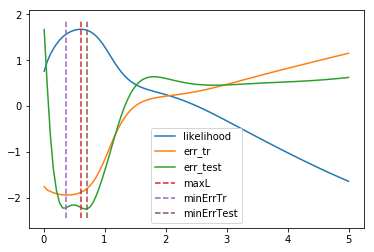

In [21]:
max_ll, argmax_ll = np.max(ll), np.argmax(ll)
min_err_tr, argmin_err_tr = np.min(err_tr), np.argmin(err_tr)
min_err_test, argmin_err_test = np.min(err_test), np.argmin(err_test)

plt.plot(test_l, ll,label='likelihood')
plt.plot(test_l, err_tr,label='err_tr')
plt.plot(test_l, err_test,label='err_test')
tmp_x = np.ones(test_l.shape[0])
ylim=plt.gca().get_ylim()
tmp_y = np.linspace(ylim[0],ylim[1], tmp_x.shape[0])
plt.plot(tmp_x*test_l[argmax_ll], tmp_y,'--', label='maxL')
plt.plot(tmp_x*test_l[argmin_err_tr], tmp_y,'--', label='minErrTr')
plt.plot(tmp_x*test_l[argmin_err_test], tmp_y,'--', label='minErrTest')

plt.legend()
print('Best lengthscale according to likelihood    :' + str(test_l[argmax_ll]))
print('Best lengthscale according to training error:' + str(test_l[argmin_err_tr]))
print('Best lengthscale according to test error    :' + str(test_l[argmin_err_test]))

The fact that the best lengthscale (according to likelihood) is not necessarily the one giving us less training error is a good property, i.e. the model avoids overfitting. 

The chosen lengthscale is also quite close to the etrue one. Running the experiment with more data will reaveal an even close match (bear in mind that numerical problems due to simple coding here might cause problems in computations).

# Part 4: Using an existing GP library

To properly optimize the kernel, we want to avoid exhaustive search of the correct parameter, especially since there are also other parameters which above we considered fixed.

The way to optimize the GP according to maximum likelihood is by using gradient information.
As a "homework", feel free to implement the gradients of the GP wrt parameters. Then, by feeding the functions of the gradients and the function of the objective (already implemented in GP.objective) to a gradient optimizer you will get automatically the result. Check the function `optimize` of `scipy`.

To save some time and effort here, we'll demonstrate the optimization with GPy [http://github.com/SheffieldML/GPy], a GP software package written in Python.

In [22]:
# Import the Gaussian process Python package
import GPy

Q = Xtr.shape[1]
k = GPy.kern.RBF(Q)
m = GPy.models.GPRegression(X=Xtr, Y=Ytr, kernel=k)


#### Print params and plot unoptimized model


Name : GP regression
Objective : 28.636961874006538
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a1e3ca860>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a1e3ca7f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a1e3ca8d0>]]}

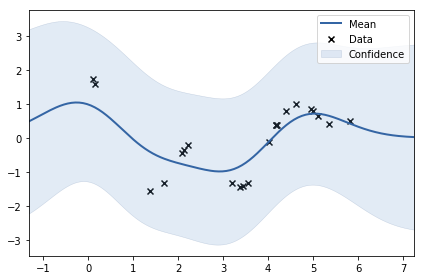

In [24]:
print(m)
m.plot()

#### Optimize using gradient method

In [25]:
m.optimize(messages=1)

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))

#### Print params and plot optimized model

Observe how the optimized lengthscale is close to the one we found before by grid search and even closer to the true one.


Name : GP regression
Objective : -27.822747981936605
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |      3.227487259467466  |      +ve      |        
  rbf.lengthscale          |     0.8751790052721424  |      +ve      |        
  Gaussian_noise.variance  |  3.059064087194654e-05  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x1a21ce1a20>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a21e013c8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a21ce1a90>]]}

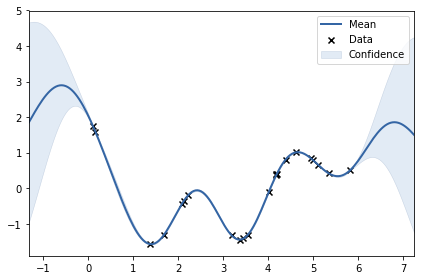

In [26]:
print(m)
m.plot()

#### Predict test data

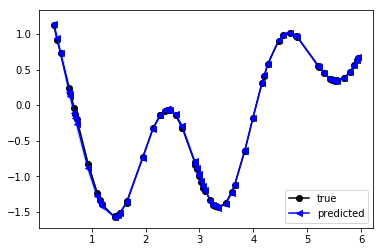

In [27]:
mu,var = m.predict(X_star)
plot_fit(X_star, Y_star, mu, var)

#### Extrapolation

So, interpolation is pretty good. How about extrapolation?


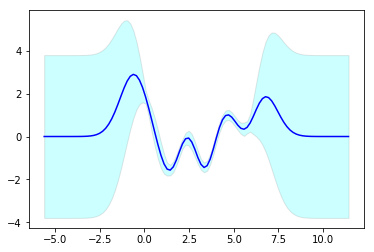

In [28]:
df = Xtr[-1]-Xtr[0]
X_extrap = np.linspace(Xtr[0]-df,2*df, 100)[:,None]
mu,var = m.predict(X_extrap)

plot_fit(X_extrap, None, mu, np.sqrt(var)*2, '', 'b-', legend=False)

Extrapolation is a much more difficult task, as there are no data in the region where we wish to predict. Therefore, the GP reverts to the mean 0. The important thing to note, is that the errorbars grow, which is a good thing, since we need our model to tell us when it is uncertain.

## Other examples

### Large uncertainty with no data in the middle

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a224d7898>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a224d7d68>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1a224d77f0>]]}

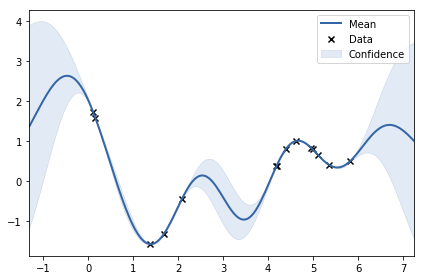

In [29]:
Xtr2 = Xtr.copy()
Ytr2 = Ytr.copy()
Xtr2 = np.vstack((Xtr2[0:5,:],Xtr2[13:,:]))
Ytr2 = np.vstack((Ytr2[0:5,:],Ytr2[13:,:]))
Q = Xtr2.shape[1]
k = GPy.kern.RBF(Q)
m = GPy.models.GPRegression(X=Xtr2, Y=Ytr2, kernel=k)
m.optimize()
m.plot()

### Classification

It's beyond the scope of this tutorial, but here's a quick flavor.

In equation (1) we saw how a regression noise model is obtained by assuming Gaussian noise. However, when our observations are binary (e.g. for classification), it's unrealistic to make this assumption. Rather, we would prefer to include a Bernoulli likelihood.

Unfortunately, if we do that then equation (1) will include a Bernoulli likelihood and then equation (3) is intractable. Gaussians tend to be great analytically but mostly when everything else is also Gaussian!

However, one can resort to approximation schemes which apprpoximate the integral.

Two popular ones is Expectation Propagation and the Laplace approximation.


Name : gp_classification
Objective : 10.33203764333977
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  3.3748275271558708  |      +ve      |        
  rbf.lengthscale     |   4.919202007587826  |      +ve      |        


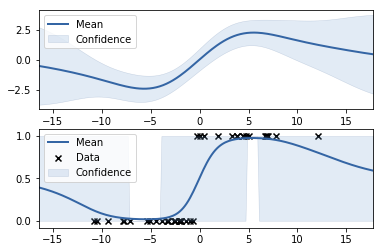

In [30]:
m = GPy.examples.classification.toy_linear_1d_classification()

In [31]:
m = GPy.examples.classification.oil()

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))


Name : SparseGPClassification
Objective : 201.00706911564293
Number of Parameters : 602
Number of Optimization Parameters : 602
Updates : True
Parameters:
  SparseGPClassification.  |              value  |  constraints  |  priors
  inducing_inputs          |           (50, 12)  |               |        
  rbf.variance             |  72.57169566054941  |      +ve      |        
  rbf.lengthscale          |  5.228991771053285  |      +ve      |        
99.5 % instances correctly classified
          |  1         |  0         | 
----------|------------|------------|
1         |  323.0     |  1         | 
0         |  4         |  672.0     | 


### Deep Gaussian processes  


A Deep Gaussian process (DGP) [1, 2] of $L$ layers is a GP whose inputs are another GP, whose inputs are another GP... (repeat $L$ times). 

Mathematically, we have:
$$
y = f_L(f_{L-1}, \dots, f_1(x)) \\
f_l \sim \mathcal{GP}(\mu_l(x), k_l(x,x')) \\
l = 1, \dots, L
$$
where we could have also introduced additive noise in each layer such to obtain $f_l(\cdot) + \epsilon_l$. 
The expressive power of a deep GP is significantly greater than that of a standard GP, because the successive warping of inputs through the hierarchy allows for modeling non-stationarities
and sophisticated, non-parametric functional "features".

_[1] Damianou A., and Lawrence N. "Deep Gaussian processes".  AISTATS, 2013_  
_[2] Damianou A. "Deep Gaussian processes and variational propagation of uncertainty". PhD Thesis, 2015_

Inference in DGPs is difficult, and beyond the scope of this tutorial. Here, we will just show how to successively warp inputs across multiple GP prior layers, in order to investigate the properties of the resulting curves.

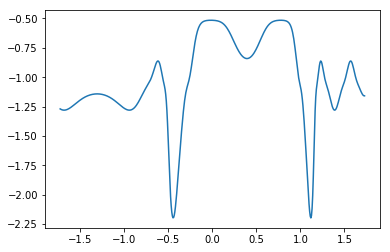

In [37]:
def layer_sample(X, cov_fn=None):
    """
    Creates a covariance and samples a noiseless zero-mean GP sample 
    with the created covariance matrix (evaluated at given inputs X). 
    """
    # Standardize data 
    X -= X.mean()
    X/=X.std()
    if cov_fn is None:
        # Sample the lengthscale uniformly to obtain varying nonstationarity effects across layers
        lengthscale = np.random.uniform(0.5,3)
        cov_fn = CovFunctions('RBF', np.array([1,lengthscale]))
    K = cov_fn.compute(X, X)
    # Return a sample from this layer
    return np.random.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K)[:,None]

def DGP_sample(X, num_layers):
    """
    Creates a sample from a hierarchy of `num_layers` GPs by propagating samples across layers. 
    """
    if num_layers == 0:
        return X
    else:
        X = layer_sample(X)
        return DGP_sample(X, num_layers-1)

X = np.linspace(-3,3, 500)[:,None]
# Plot a DGP sample from a DGP of 5 layers.
plt.plot(X, DGP_sample(X, num_layers = 5))

As can be seen, the DGP sample has properties that we would not expect to see in a sample from a "vanilla" GP. Firstly, there seems to be a symmetry between around $-0.6$ and $1.2$. Secondly, we see that the overall process exhibits non-stationarity, since the curve is very smooth at some intervals and very "rough" at others. The long-range correlations and non-stationarity is a result of the functional features created when we warp the input space. 

# If you want to learn more:

Just some of the many helpful sources:


* GP book: http://www.gaussianprocess.org/gpml/ 
* Gaussian process summer school in Sheffield: http://gpss.cc/
* GPy software and tutorials: https://sheffieldml.github.io/GPy/
* Plenty of tutorials online on videolectures.net 

This notebook has been inspired by the lectures of N. D. Lawrence, D.J.C. MacKay, C. E. Rasmussen, M. Girolami. Thanks to the GPy developer team.

## EOF